In [92]:
import sys
sys.path.insert(0, '../..')

# PARAMETERS
platesolve_file = "baseline_2_ps.csv"
sensor_file = "obs_test2_2023-02-03.txt"
sensor_timezone = -5  # GMT-5
sensor_date = "2023-02-03"

# Degrees
true_latitude = 37.22184227
true_longitude = -80.46177509

In [93]:
from astropy import units as u
from astropy.coordinates import Angle
from zenith_to_latlon_error import get_latlon
from multilateration import multilateration, angular_dist
import time
from dataclasses import dataclass
from typing import Tuple
from typing import List


@dataclass
class StarInfo:
    ra: Angle
    dec: Angle 
    alt: Angle
    time: Tuple[int]

    def zd(self): 
        return Angle('90d') - self.alt

    def latlon(self):
        return get_latlon(*self.time, self.ra, self.dec)


@dataclass
class MultilaterationResult:
    elapsed_time: float
    lat: Angle
    lon: Angle
    alt_bias: Angle
    err_angular: Angle
    err_nm: float

    def __str__(self):
        out = ""
        out += f"Elapsed: {self.elapsed_time}s\n"
        out += f"Latitude: {self.lat.to_string(unit=u.degree)}\n"
        out += f"Longitude: {self.lon.to_string(unit=u.degree)}\n"
        out += f"Alt. Bias: {self.alt_bias.to_string(unit=u.degree)}\n"
        out += f"Err. Angular Separation: {self.err_angular.to_string(unit=u.degree)} \n"
        out += f"Err. in NM: {self.err_nm}\n"
        return out


def run_multilateration(actual_latitude: Angle, actual_longitude: Angle, stardata: List[StarInfo]) -> MultilaterationResult:
    # radian vs radians below is because lat / lon coordinates are Skyfield Angles
    # whereas the zd coordiantes are astropy angles
    points = [([l.radians for l in p.latlon()], p.zd().radian) for p in stardata]

    before = time.time()
    result_lat_rads, result_lon_rads, result_alt_bias_rads = multilateration(points).x
    elapsed = time.time() - before

    result_lat = Angle(result_lat_rads, u.radian)
    result_lon = Angle(result_lon_rads, u.radian)
    result_alt_bias = Angle(result_alt_bias_rads, u.radian)

    error_angular = angular_dist((result_lat.radian, result_lon.radian), (actual_latitude.radian, actual_longitude.radian))
    error_angular = Angle(error_angular, u.radian)

    error_nm = error_angular.arcminute

    return MultilaterationResult(elapsed, result_lat, result_lon, result_alt_bias, error_angular, error_nm)

                        time         x        y        z
0    2023-02-04 02:20:48.451  359.8242  44.2255  45.7690
1    2023-02-04 02:20:48.615  359.9451  44.0552  45.9393
2    2023-02-04 02:20:48.865  359.6704  44.1870  45.8075
3    2023-02-04 02:20:49.115  359.6265  44.0717  45.9174
4    2023-02-04 02:20:49.365  359.9506  44.4287  45.5548
...                      ...       ...      ...      ...
2613 2023-02-04 02:32:23.076  359.9780  49.5264  40.4681
2614 2023-02-04 02:32:23.451    7.0972  62.1332  26.7847
2615 2023-02-04 02:32:23.811   10.1404  68.2965  18.9624
2616 2023-02-04 02:32:24.158   13.1836  69.2743  15.6830
2617 2023-02-04 02:32:24.440   12.0410  69.8071  15.9412

[2618 rows x 4 columns]


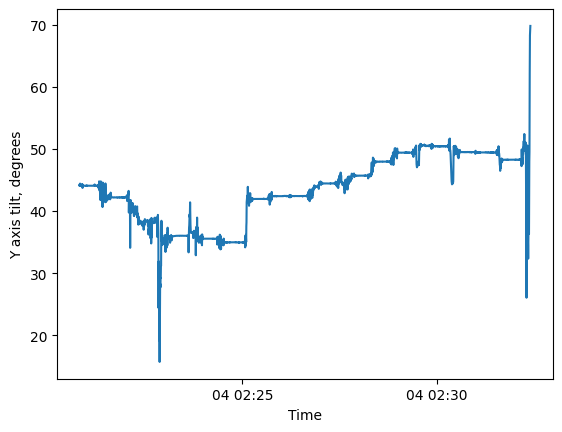

In [94]:

import pandas as pd
import re
from matplotlib import pyplot as plt


def parse_line(line: str, date: str) -> pd.Series:
    result = re.match(r"([0-9.:]+)\s*X Tilt: ([0-9]+\.[0-9]+).*Y Tilt: ([0-9]+\.[0-9]+).*Z Tilt: ([0-9]+\.[0-9]+)\s*", line)
    row = pd.Series({
        "time": pd.Timestamp(f"{date} {result.group(1)}") - pd.Timedelta(hours=sensor_timezone),
        "x": float(result.group(2)),
        "y": float(result.group(3)),
        "z": float(result.group(4))
    })
    return row


def read_sensor_txt(path: str, date: str) -> pd.DataFrame:
    with open(path) as file:
        df = pd.DataFrame(parse_line(line, date) for line in file.readlines())
    
    return df
        

data = read_sensor_txt(sensor_file, sensor_date)
print(data)

plt.figure()
plt.plot(data['time'], data['y'])
plt.ylabel("Y axis tilt, degrees")
plt.xlabel("Time")
plt.show()

In [95]:
def get_averaged_reading(reading_data: pd.DataFrame, col: str, exposure_start: pd.Timestamp, exposure_duration: pd.Timedelta, actual_alt) -> float:
    our_data = reading_data[reading_data['time'].between(exposure_start, exposure_start + exposure_duration)]
    median = our_data[col].median()
    mean = our_data[col].mean()
    plt.figure()
    plt.plot(our_data['time'],our_data[col])
    plt.ylabel(col)
    plt.xlabel('time')
    plt.axhline(median, color='r')
    plt.axhline(mean, color='b')
    plt.axhline(actual_alt, color='g')
    plt.legend(['alt. data', 'median', 'mean', 'actual'])
    plt.show()
    return median


def get_angle(reading_data: pd.DataFrame, exposure_start: pd.Timestamp, exposure_duration: pd.Timedelta, actual_alt) -> Angle:
    average = get_averaged_reading(reading_data, 'y', exposure_start, exposure_duration, actual_alt)
    return Angle(average, unit=u.deg)



            ra        dec      date     time
0   146.540206  36.727425  2/4/2023  2:21:06
1   155.706557  55.689208  2/4/2023  2:21:50
2   175.839745  70.268201  2/4/2023  2:24:11
3   304.980225  87.602823  2/4/2023  2:24:44
4    94.729049  84.985410  2/4/2023  2:25:28
5    22.332880  64.849751  2/4/2023  2:26:28
6    28.685567  43.945985  2/4/2023  2:27:15
7    40.466956  24.449188  2/4/2023  2:28:06
8    57.910926   8.085242  2/4/2023  2:28:39
9    77.676911  -0.779606  2/4/2023  2:29:12
10   95.682412  -1.942913  2/4/2023  2:30:07
11  116.667157   4.727896  2/4/2023  2:30:49


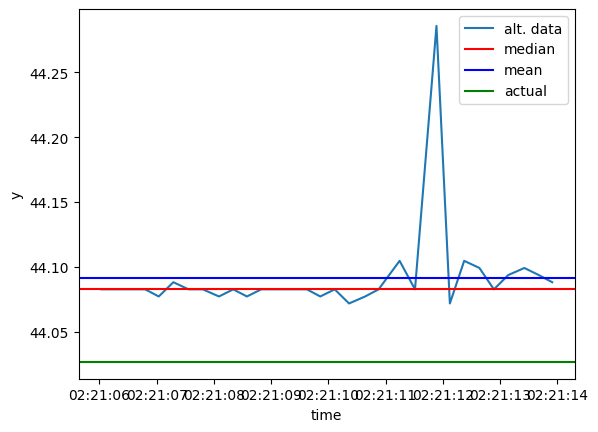

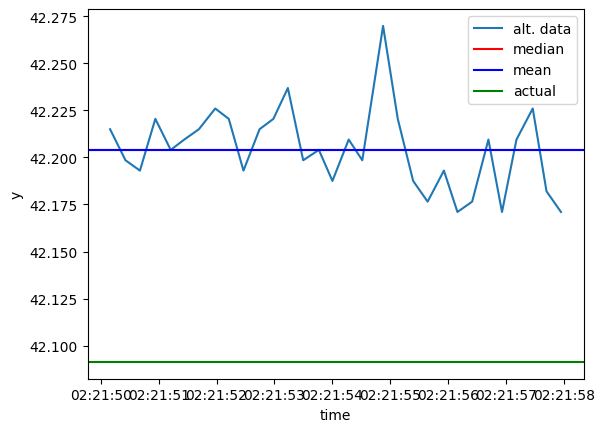

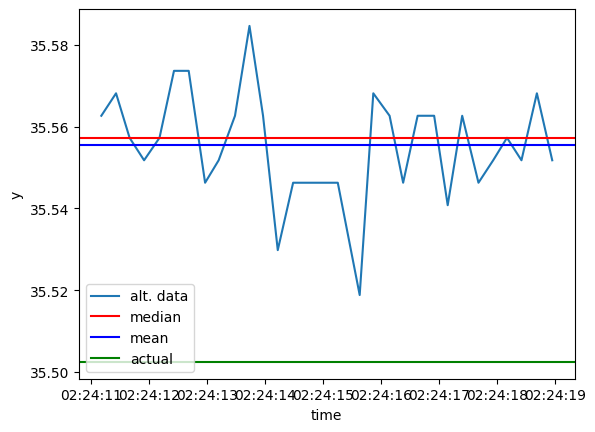

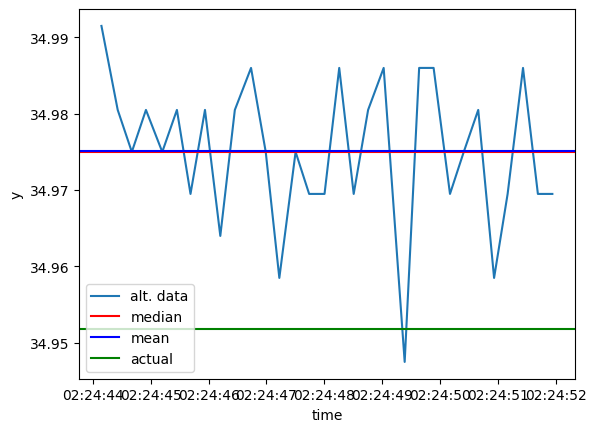

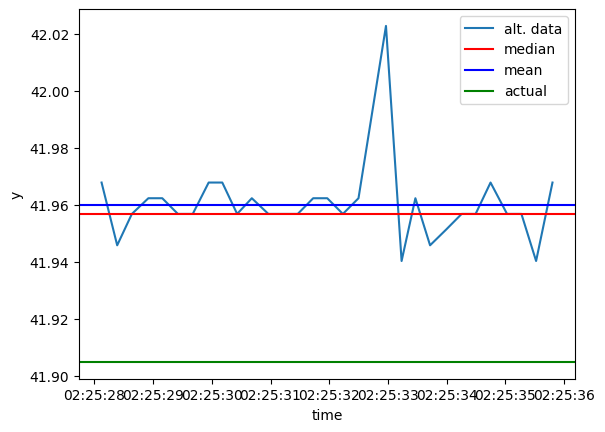

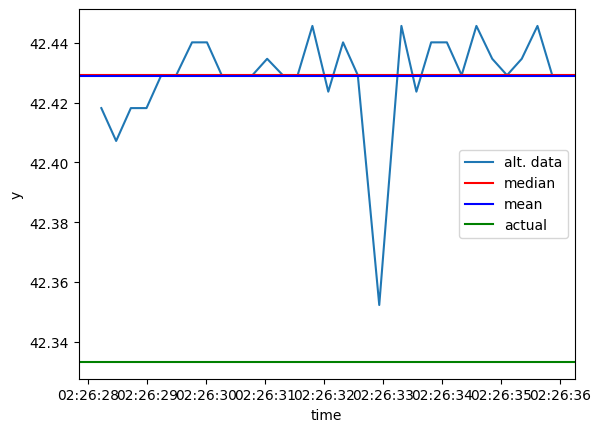

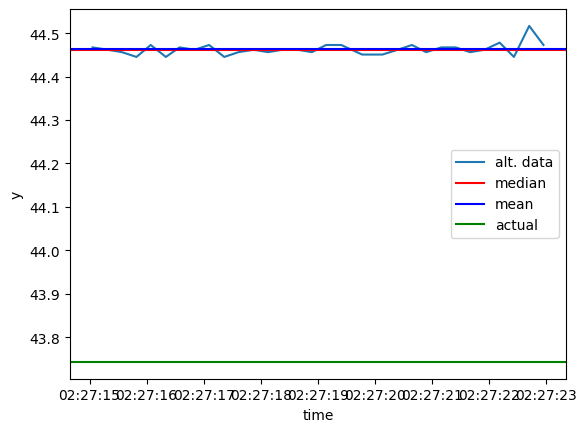

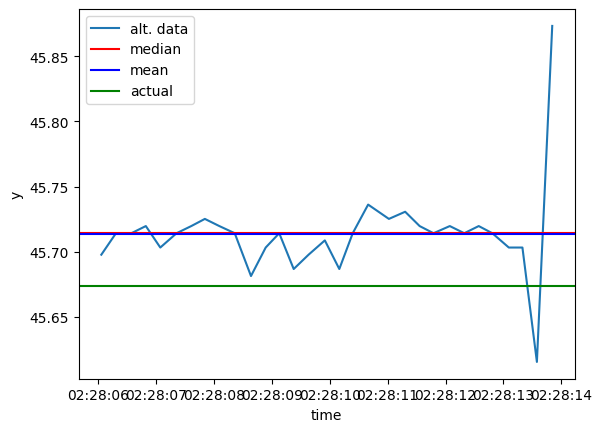

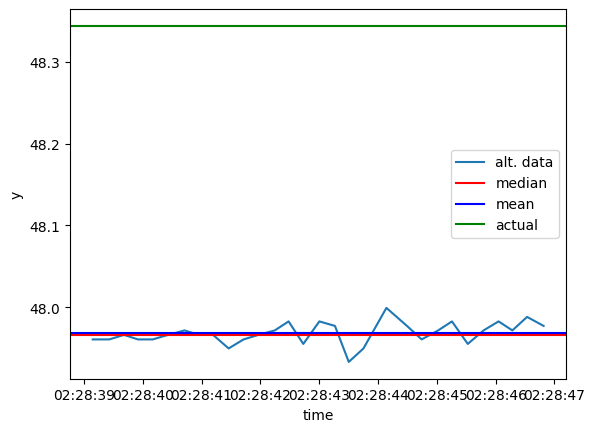

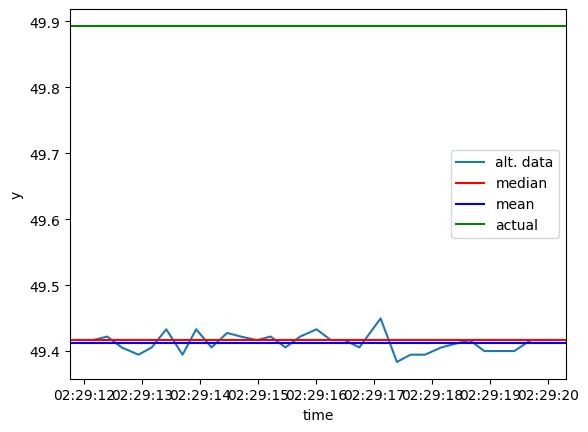

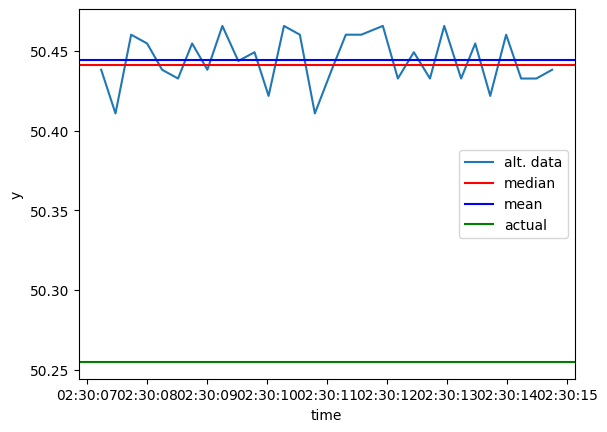

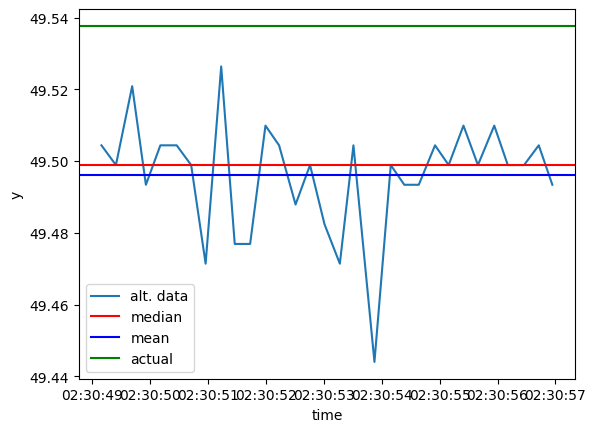

[StarInfo(ra=<Angle 146.5402058 deg>, dec=<Angle 36.72742463 deg>, alt=<Angle 44.0826 deg>, time=(2023, 2, 4, 2, 21, 6)),
 StarInfo(ra=<Angle 155.7065572 deg>, dec=<Angle 55.68920816 deg>, alt=<Angle 42.204 deg>, time=(2023, 2, 4, 2, 21, 50)),
 StarInfo(ra=<Angle 175.839745 deg>, dec=<Angle 70.26820088 deg>, alt=<Angle 35.5573 deg>, time=(2023, 2, 4, 2, 24, 11)),
 StarInfo(ra=<Angle 304.9802253 deg>, dec=<Angle 87.60282268 deg>, alt=<Angle 34.975 deg>, time=(2023, 2, 4, 2, 24, 44)),
 StarInfo(ra=<Angle 94.72904891 deg>, dec=<Angle 84.9854097 deg>, alt=<Angle 41.9568 deg>, time=(2023, 2, 4, 2, 25, 28)),
 StarInfo(ra=<Angle 22.33288007 deg>, dec=<Angle 64.84975125 deg>, alt=<Angle 42.4292 deg>, time=(2023, 2, 4, 2, 26, 28)),
 StarInfo(ra=<Angle 28.68556728 deg>, dec=<Angle 43.94598492 deg>, alt=<Angle 44.4617 deg>, time=(2023, 2, 4, 2, 27, 15)),
 StarInfo(ra=<Angle 40.46695617 deg>, dec=<Angle 24.44918819 deg>, alt=<Angle 45.7141 deg>, time=(2023, 2, 4, 2, 28, 6)),
 StarInfo(ra=<Angle 57

In [96]:
import pandas as pd

duration = pd.Timedelta(seconds=8)
ps_data = pd.read_csv(platesolve_file)
print(ps_data)

def get_date_tuple(datestr, timestr):
    month, day, year = [int(x) for x in datestr.split('/')]
    hour, min, sec = [int(x) for x in timestr.split(':')]
    return (year, month, day, hour, min, sec)

actual_altitudes = pd.read_csv("altitudes.csv")['actual']
actual_alt_bias = -0.2978565117550841

# Note we are GMT-5, so must correct in `time=`
real_stardata = [StarInfo(
    ra=Angle(ra, unit=u.degree),
    dec=Angle(dec, unit=u.degree),
    alt=get_angle(
        data,
        pd.Timestamp(f"{date} {time}"),
        duration,
        actual+actual_alt_bias
    ),
    time=get_date_tuple(date,time)
) for ra,dec,date,time,actual in zip(ps_data['ra'], ps_data['dec'], ps_data['date'], ps_data['time'], actual_altitudes)]
real_stardata

In [101]:
result = run_multilateration(
    Angle(true_latitude, unit=u.degree), 
    Angle(true_longitude, unit=u.degree), 
    # [real_stardata[1], real_stardata[6], real_stardata[9]]
    # real_stardata
    [real_stardata[i] for i in range(len(real_stardata)) if i not in [6, 8, 9]]
)
print(str(result))

print("RESULT:")
print(result.lat.deg)
print(result.lon.deg)

print()
print("ACTUAL:")
print(Angle(true_latitude, unit=u.degree).deg)
print(Angle(true_longitude, unit=u.degree).deg)

Elapsed: 0.007752418518066406s
Latitude: 37d12m39.48836877s
Longitude: -80d28m07.47219611s
Alt. Bias: -0d14m13.24700055s
Err. Angular Separation: 0d00m43.94545191s 
Err. in NM: 0.7324241985071157

RESULT:
37.21096899132366
-80.4687422766975

ACTUAL:
37.22184227
-80.46177509


-0.2978565117550841


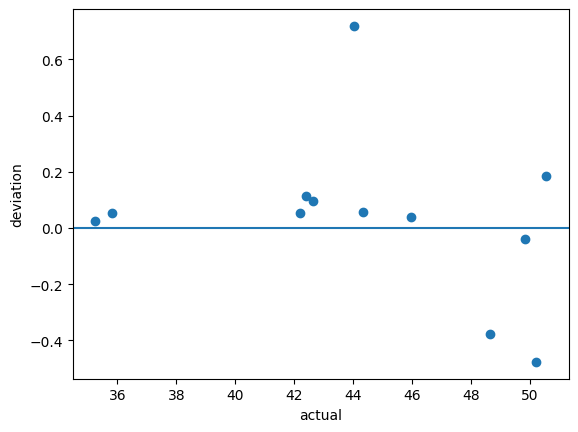

In [98]:
altitudes = pd.read_csv("altitudes.csv")
altitudes['measured'] -= result.alt_bias.deg
print(result.alt_bias.deg)
plt.figure()
plt.scatter(altitudes['actual'], altitudes['measured'] - altitudes['actual'])
plt.xlabel('actual')
plt.axhline(y=0)
plt.ylabel('deviation')
plt.show()

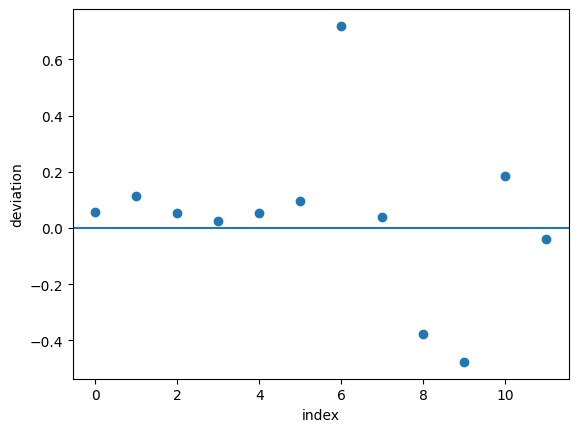

In [100]:

plt.figure()
plt.plot(altitudes['measured'] - altitudes['actual'], 'o')
plt.xlabel('index')
plt.axhline(y=0)
plt.ylabel('deviation')
plt.show()